In [1]:
from time import time
import psycopg2
from collections import Counter
import gc
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
np.set_printoptions(suppress=True,precision=10)

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression

In [3]:
def selectMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT m.subject_id,m.word,m.counting,s.isalive "
                      " FROM matrix m LEFT JOIN subjectwords s ON m.subject_id=s.subject_id "
     #                 " WHERE m.word in (select word from wordspearson where p1>0.01 order by p1 limit 400) "
    )
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append((row))
    cur.close()
    conn.close()
    return select

In [4]:
def convertMatrix() :
    labels = ['subject_id', 'Word', 'Counting','isAlive']
    df = pd.DataFrame.from_records(selectMatrix(), columns=labels)
    print(len(df))
    table = pd.pivot_table(df,index=["subject_id","isAlive"],columns=["Word"],values=["Counting"],
                       aggfunc={"Counting":[np.sum]},fill_value=0)
    table.columns = [value[2] for value in table.columns.values]
    return table

In [5]:
t0=time()
table = convertMatrix()
print("converMatrix done in %0.3fs." % (time() - t0))
print(table.shape)
gc.collect()

80779
converMatrix done in 0.649s.
(729, 232)


14

In [6]:
survived = table.index.labels[1].tolist()
patients = table.values

In [7]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [8]:
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(729, 232)
(583, 232)
(146, 232)


### Base Model All Will Die

In [9]:
def base_rate_model(X) :
    y = np.ones(X.shape[0])
    return y

In [10]:
y_base_rate = base_rate_model(patients_test)
print("Base rate acurracy is %2.2f" % accuracy_score(survived_test,base_rate_model(patients_test)))
base_roc_auc = roc_auc_score(survived_test,base_rate_model(patients_test))

Base rate acurracy is 0.78


### AUC

In [11]:
def aucModel(name,survived_test,model,patients_test):
    logit_roc_auc = roc_auc_score(survived_test,model.predict(patients_test))
    print(name+" AUC = %2.2f2f"% logit_roc_auc)
    return logit_roc_auc

### Direct Regresion Logistic

In [12]:
model = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)
logit_roc_auc = aucModel("Logistic",survived_test,model,patients_test)

acurracy is 0.77
Logistic AUC = 0.582f


### NMF + Logistic Regression accurancy

In [13]:
def generateNMF(patients_train,survived_train,patients_test,survived_test,n_components=30) :
    nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5)
    patients_trainnmf = nmf.fit_transform(patients_train)
    H = nmf.components_
    patients_testnmf = nmf.transform(patients_test)
    modelnmf = ajustLogisticRegression(patients_trainnmf,survived_train,patients_testnmf,survived_test)
    return modelnmf,patients_testnmf

In [14]:
values = [10,29,37,44,84] #61,79,98,115,132
nmfResult = []
for value in values :
    modelnmf,pat_testnmf = generateNMF(patients_train,survived_train,patients_test,survived_test,n_components=value)
    name = "NMF "+str(value)
    nmf_roc_auc = aucModel(name,survived_test,modelnmf,pat_testnmf)
    nmfResult.append({'name':name,'model':modelnmf,'patients':pat_testnmf,'roc_auc':nmf_roc_auc})

acurracy is 0.79
NMF 10 AUC = 0.602f
acurracy is 0.77
NMF 29 AUC = 0.542f
acurracy is 0.77
NMF 37 AUC = 0.552f
acurracy is 0.76
NMF 44 AUC = 0.602f


In [15]:
accuracyScore,bestScore,nmf_roc_auc = 0,0,0
for x in range(91,120):
    modelnmfNew,pat_testnmfNew = generateNMF(patients_train,survived_train,patients_test,survived_test,n_components=x)
    newAccuracy = accuracy_score(survived_test,modelnmfNew.predict(pat_testnmfNew))
    newroc_auc = aucModel("NMF "+str(x),survived_test,modelnmfNew,pat_testnmfNew)
    if newroc_auc>nmf_roc_auc:
        modelnmf,pat_testnmf=modelnmfNew,pat_testnmfNew
        accuracyScore,bestScore,nmf_roc_auc=newAccuracy,x,newroc_auc
print("bestScore "+str(bestScore)+" accurracy is %2.2f"% accuracyScore)
print(classification_report(survived_test,modelnmf.predict(pat_testnmf)))

acurracy is 0.77
NMF 61 AUC = 0.612f
acurracy is 0.76
NMF 62 AUC = 0.622f
acurracy is 0.75
NMF 63 AUC = 0.632f
acurracy is 0.75
NMF 64 AUC = 0.602f
acurracy is 0.76
NMF 65 AUC = 0.592f
acurracy is 0.76
NMF 66 AUC = 0.582f
acurracy is 0.79
NMF 67 AUC = 0.622f
acurracy is 0.78
NMF 68 AUC = 0.612f
acurracy is 0.79
NMF 69 AUC = 0.622f
acurracy is 0.75
NMF 70 AUC = 0.592f
acurracy is 0.75
NMF 71 AUC = 0.592f
acurracy is 0.75
NMF 72 AUC = 0.592f
acurracy is 0.75
NMF 73 AUC = 0.612f
acurracy is 0.78
NMF 74 AUC = 0.592f
acurracy is 0.77
NMF 75 AUC = 0.602f
acurracy is 0.77
NMF 76 AUC = 0.612f
acurracy is 0.78
NMF 77 AUC = 0.612f
acurracy is 0.78
NMF 78 AUC = 0.632f
acurracy is 0.77
NMF 79 AUC = 0.622f
acurracy is 0.75
NMF 80 AUC = 0.582f
acurracy is 0.78
NMF 81 AUC = 0.612f
acurracy is 0.78
NMF 82 AUC = 0.622f
acurracy is 0.77
NMF 83 AUC = 0.602f
acurracy is 0.79
NMF 84 AUC = 0.652f
acurracy is 0.78
NMF 85 AUC = 0.622f
acurracy is 0.79
NMF 86 AUC = 0.652f
acurracy is 0.79
NMF 87 AUC = 0.652f
a

In [16]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [17]:
def roc_curveplot(name,survived_test,model,patients_test,logit_roc_auc):
    fpr, tpr, thresholds = roc_curve(survived_test,model.predict_proba(patients_test)[:,1])
    plt.plot(fpr,tpr,label='ROC '+name+' curve (AUC =%0.2f)' % logit_roc_auc)

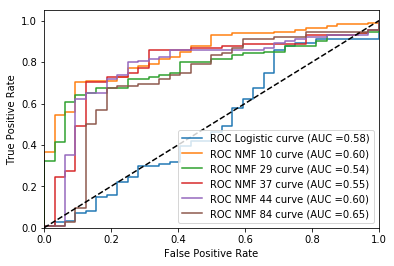

In [18]:
plt.figure()
roc_curveplot('Logistic',survived_test,model,patients_test,logit_roc_auc)
for resul in nmfResult : 
    roc_curveplot(resul['name'],survived_test,resul['model'],resul['patients'],resul['roc_auc'])
roc_curveplot('NMF '+str(bestScore),survived_test,modelnmf,pat_testnmf,nmf_roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()